In [1]:
import torch
import torch.nn as nn




In [3]:


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

# Define the input shape and other parameters
input_size = 1
hidden_size = 50
num_layers = 3  # Assuming you want to keep the number of layers the same
output_size = 1

# Create an instance of the LSTMModel
model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Assuming you have already scaled your data
# X_train, X_test, y_train, y_test

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 1
hidden_size = 50
num_layers = 3
output_size = 1

# Create an instance of the LSTMModel
model = LSTMModel(input_size, hidden_size, num_layers, output_size)




In [5]:
import pandas as pd 
import numpy as np

In [7]:
df= pd.read_csv(r"C:\Users\Z004ET6Z\pfs\edv\time series 2024]\projects\crudeprice.csv")

In [8]:
df.columns = ["Date","Price"]

In [9]:
df = df[df["Price"]!="."]

In [10]:
df["Price"] = df["Price"].apply(lambda x: float(x))

In [11]:
df1 = df.reset_index()['Price']

In [12]:
# scaling data

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
w = 100

In [16]:
#train- test split

train_size = int(len(df1)*0.95)
test_size = len(df1) - train_size 

In [17]:
train_data = df1[:train_size+w:]
test_data = df1[train_size::]

In [18]:
train_data.shape,test_data.shape

((8736, 1), (455, 1))

In [19]:
def create_dataset(dataset,time_step):
    dataX,dataY = [], []

    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])

    return np.array(dataX), np.array(dataY)

In [20]:
train_data = np.array(train_data).reshape(-1,1)
test_data = np.array(test_data).reshape(-1,1)

In [21]:
time_step = w
#Using 100 consecutive values predicting 101th value
#f1-------f100 = X
#f101 = y
X_train, y_train = create_dataset(train_data,time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [22]:
#Making data 3D
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [28]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# # Convert data to PyTorch tensors
# X_train_torch = torch.tensor(X_train).float()
# y_train_torch = torch.tensor(y_train).float()
# X_test_torch = torch.tensor(X_test).float()
# y_test_torch = torch.tensor(y_test).float()

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train.reshape(-1, 100, 1)).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(X_test.reshape(-1, 100, 1)).float()
y_test_torch = torch.tensor(y_test).float()




In [30]:
# Training loop
epochs = 2
batch_size = 128
for epoch in range(epochs):
    for i in range(0, len(X_train_torch), batch_size):
        inputs = X_train_torch[i:i+batch_size]
        labels = y_train_torch[i:i+batch_size]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
    
    # Validation
    with torch.no_grad():
        outputs = model(X_test_torch)
        val_loss = criterion(outputs, y_test_torch)
        print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss.item()}')

print('Training finished')

c:\Users\Z004ET6Z\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Z004ET6Z\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([355])) that is different to the input size (torch.Size([355, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/2], Validation Loss: 0.4995335638523102
Epoch [2/2], Validation Loss: 0.31258201599121094
Training finished


In [42]:
# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs = model(X_test_torch)

# Convert the predictions to numpy arrays
test_predictions = test_outputs.numpy()

# Print the first few predictions
print("Predictions on test data:")
print(test_predictions)


Predictions on test data:
[[1.1857433 ]
 [1.1917124 ]
 [1.2022606 ]
 [1.2187556 ]
 [1.22244   ]
 [1.2289867 ]
 [1.2290001 ]
 [1.2288616 ]
 [1.2187669 ]
 [1.1999851 ]
 [1.1785129 ]
 [1.1736724 ]
 [1.1745667 ]
 [1.145757  ]
 [1.1039011 ]
 [1.0875678 ]
 [1.0902534 ]
 [1.1133564 ]
 [1.1251554 ]
 [1.1370677 ]
 [1.1415994 ]
 [1.1328467 ]
 [1.1295223 ]
 [1.1063753 ]
 [1.0984482 ]
 [1.0748457 ]
 [1.0584071 ]
 [1.0716476 ]
 [1.0828356 ]
 [1.0898664 ]
 [1.0003493 ]
 [0.9098249 ]
 [0.8154581 ]
 [0.731067  ]
 [0.6742652 ]
 [0.63866776]
 [0.63922745]
 [0.6760822 ]
 [0.7327389 ]
 [0.77602875]
 [0.8146364 ]
 [0.83353966]
 [0.8321852 ]
 [0.8240532 ]
 [0.82058114]
 [0.8032771 ]
 [0.76431215]
 [0.7443473 ]
 [0.74798226]
 [0.77464944]
 [0.7991227 ]
 [0.8513896 ]
 [0.9043123 ]
 [0.93417066]
 [0.95759207]
 [0.9818278 ]
 [1.0108283 ]
 [1.0477049 ]
 [1.0815989 ]
 [1.0993629 ]
 [1.1399701 ]
 [1.1865252 ]
 [1.2246175 ]
 [1.2638221 ]
 [1.2996291 ]
 [1.3343343 ]
 [1.3669505 ]
 [1.391783  ]
 [1.4079564 ]
 [1.4008

In [41]:
# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs = model(X_train_torch)

# Convert the predictions to numpy arrays
train_predictions = test_outputs.numpy()

# Print the first few predictions
print("Predictions on test data:")
print(test_predictions)

Predictions on test data:
[[-0.35067093]
 [-0.35057944]
 [-0.35050583]
 ...
 [ 1.15346   ]
 [ 1.164088  ]
 [ 1.1727011 ]]


In [33]:
X_test_torch.shape

torch.Size([355, 100, 1])

In [34]:
test_predictions.shape

(355, 1)

In [35]:
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test,test_predictions))

0.20484342810264725

In [37]:
import matplotlib.pyplot as plt 

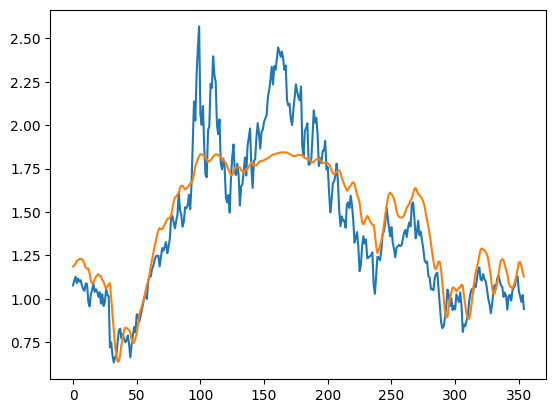

In [44]:
plt.plot(y_test)
plt.plot(test_predictions)


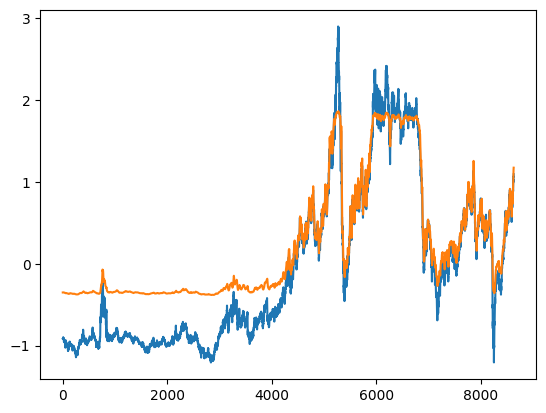

In [45]:
plt.plot(y_train)
plt.plot(train_predictions)